# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Conv2D,MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style = 'white', context = 'notebook', palette = 'deep')


Using TensorFlow backend.


In [20]:
train = pd.read_csv('./Dataset/train.csv')
test = pd.read_csv('./Dataset/test.csv')

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

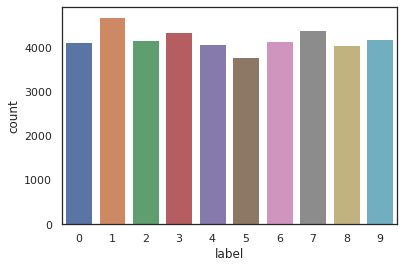

In [21]:
Y_train = train['label']

X_train = train.drop(labels = ['label'],axis = 1)

del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [22]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [23]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [24]:
# Normlize the data
X_train = X_train/255.0
test = test/255.0

In [25]:
# Reshape image in 3 dimensions (height = 28px, width = 28px, cannal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [26]:
# Encode labels to one hot vectors(ex: 2-> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train,num_classes = 10)

In [27]:
random_seed = 2

In [28]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,test_size = 0.1, random_state = random_seed)

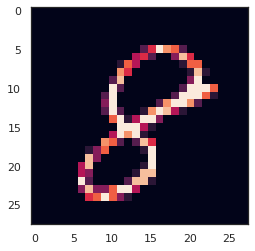

In [29]:
g = plt.imshow(X_train[0][:,:,0])

In [30]:
#  CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [31]:
# Define the optimizer
optimizer = RMSprop(lr = 0.001,rho = 0.9,epsilon = 1e-08,decay = 0.0)


In [32]:
model.compile(optimizer,loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [33]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(moniter = 'val_acc',patience = 3,verbose = 1,factor = 0.5,min_lr = 0.00001)

In [34]:
epochs = 3 # Turn epochs to 30 to get 0.9967 accuracy
batch_size= 86

In [35]:
# With data augmentation to prevent overfitting (accuracy 0.99286)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [36]:
# Fit the model 
history = model.fit_generator(datagen.flow(X_train,Y_train,batch_size = batch_size),epochs = epochs, validation_data = (X_val,Y_val),verbose = 2, steps_per_epoch = X_train.shape[0] // batch_size, callbacks = [learning_rate_reduction])

Epoch 1/3
 - 197s - loss: 0.4332 - accuracy: 0.8594 - val_loss: 0.0609 - val_accuracy: 0.9807
Epoch 2/3
 - 192s - loss: 0.1281 - accuracy: 0.9615 - val_loss: 0.0744 - val_accuracy: 0.9767
Epoch 3/3
 - 208s - loss: 0.0937 - accuracy: 0.9722 - val_loss: 0.0331 - val_accuracy: 0.9902


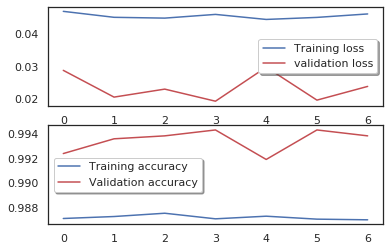

In [35]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'],color = 'b',label = "Training loss")
ax[0].plot(history.history['val_loss'],color = 'r',label = "validation loss",axes = ax[0])
legend = ax[0].legend(loc = 'best',shadow = True)

ax[1].plot(history.history["accuracy"], color='b', label="Training accuracy")
ax[1].plot(history.history["val_accuracy"], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

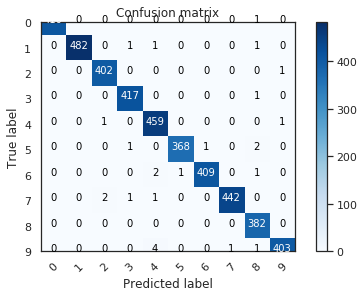

In [36]:
# Look at confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


In [37]:
len(Y_pred_classes)

4200

In [38]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [39]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

In [2]:
from mnist import MNIST

mndata = MNIST('./samples/')

images, labels = mndata.load_training()
# or
#images, labels = mndata.load_testing()

In [8]:
import random 

index = random.randrange(0, len(images))  # choose an index ;-)
print(mndata.display(images[index]))


............................
............................
..................@.........
.................@@@........
.................@@.........
................@@@.........
...............@@...........
..............@@@...........
.............@@.............
.............@..............
............@@..............
...........@@...............
...........@@....@@.........
..........@@...@@@@@........
..........@...@@@@@@........
.........@@..@@@@@@@........
.........@.@@@@...@@........
.........@.@@@....@@........
.........@@@@.....@.........
.........@@@@@@@@@..........
..........@@@@..............
..........@.................
............................
............................
............................
............................
............................
............................
